In [2]:
import numpy as np
import cupy as cp
import idx2numpy
import matplotlib.pyplot as plt
import pickle
import os


print(cp.cuda.runtime.getDeviceCount())

1


In [3]:
class prepare():
    # normalizers the features to have L2 sum of 1
    def __init__(self):
        self.normers = {}
        
    def fit_transform(self, i, j, train_data, train_label):
        X = cp.array(train_data ,dtype=float).T / 255
        X_normer = cp.sqrt(cp.sum(X*X, axis=1))
        self.normers[(i,j)] = X_normer

        X = cp.transpose (X.T / X_normer)
        X[cp.isnan(X)] = 0
        
        y = cp.array(train_label)
        y = cp.where(y==i, 1,-1).astype(cp.int8)

        return X, y
        
    def transform(self, i, j, data, label=None):
        X = cp.array(data, dtype=float).T / 255
        X = cp.transpose (X.T / self.normers[(i,j)])
        X[cp.isnan(X)] = 0

        if label is not None:
            y = cp.array(label)
            y = cp.where(y==i, 1,-1).astype(cp.int8)
            return X,y
        return X
                
    

In [4]:
class ensemble_SVMs():
    def __init__(self, kernel='rbf', optimizer='smo', threshold=0.001, 
                 max_epochs=200_000, C=10, gamma=9.0, recal_bads=100, lr=1.0, batch_size=2, debug=1,
                smo_chooser=1,smo_calc_loss=300):
        self.kernel = kernel        # kernel type
        self.max_epochs = max_epochs   # max epochs in PGD
        self.threshold = threshold     # threshold to filter out support vectors
        self.gamma = gamma
        self.losses = []
        self.C = C     # C for the soft-margin term
        self.recal_bads = recal_bads #how often (epoch) re calculate the KKT bads
        self.smo_chooser = smo_chooser

        self.optimizer = optimizer  # which optimizer is used to solve quadratic programming
        self.lr = lr                # max learning rate in PGD
        self.batch_size = batch_size 
        self.debug = debug
        self.sum_all_moves = 0
        self.smo_calc_loss = smo_calc_loss

        self.SVMs = {}
        self.normerBoy = prepare()
    
    # load saved models
    def load(self,folder_path):
        for i in range(9):
            for j in range(i+1,10):
                name = "SVM_"+str(i)+"_"+str(j)+".pkl"
                with open(os.path.join(folder_path, name),"rb") as f:
                   self.SVMs[(i,j)] = pickle.load(f)
        name = "normers.pkl"
        with open(os.path.join(folder_path, name),"rb") as f:
            self.normerBoy = pickle.load(f)
            
    def fit(self, train_data, train_label,save=False,path=""):
        train_class_idx = []
        for i in range(10):
            train_class_idx.append(train_label==i)
            # test_class_idx.append(test_label==i)
        
        self.SVMs = {}
        self.normers = {}
        for i in range(9):
            for j in range(i+1,10):

                
                train_idxs = np.logical_or(train_class_idx[i], train_class_idx[j])
                X,y = self.normerBoy.fit_transform (i,j,train_data[train_idxs], train_label[train_idxs])
        
                self.SVMs[(i,j)] = mySVM(kernel=self.kernel, optimizer=self.optimizer,
                        threshold=self.threshold, max_epochs=self.max_epochs, 
                        C=self.C, gamma=self.gamma, recal_bads=self.recal_bads, lr=self.lr, 
                        batch_size=self.batch_size, debug=self.debug,smo_chooser=self.smo_chooser,
                        smo_calc_loss=self.smo_calc_loss)
                self.SVMs[(i,j)].fit(X,y)
                if save:
                    name = "SVM_"+str(i)+"_"+str(j)+".pkl"
                    self.SVMs[(i,j)].save(os.path.join(path,name))
                print(i,j)
        if save:
            with open(os.path.join(path,"normers.pkl"), 'wb') as f:
                pickle.dump(self.normerBoy, f)
           
    def predict(self,data,ret_full=False):

        # take votes. resolve ties randomly
        def find_best(full):
            offset = cp.outer(cp.ones(full.shape[0],dtype=cp.int8) ,cp.arange(full.shape[-1],dtype=cp.int8))
            votes = (offset - full.sum(axis=-2,dtype=cp.int8)) + full.sum(axis=-1,dtype=cp.int8)
            return cp.argmax(votes,axis=1)

        # take votes. find the top votes. compare the top candidates with each other. keep going recursivly to find the final best.
        def find_best_smarter(full, ok = True):
            offset = cp.arange(full.shape[-1],dtype=cp.int8)
            votes = (offset - full.sum(axis=-2,dtype=cp.int8)) + full.sum(axis=-1,dtype=cp.int8)
            
            max_val = votes.max()
            
            if ok:
                arg_maxes = cp.logical_or(max_val==votes, (max_val-1)==votes)
            else:
                arg_maxes = max_val==votes

            if arg_maxes.all():
                return cp.random.randint(0,len(arg_maxes),)
            arg_maxes = cp.nonzero(arg_maxes)[0]

            if len(arg_maxes)==0:
                print ("Error, no max?")
                return
                
            if len(arg_maxes)==1:
                return arg_maxes[0]
            else:
                return arg_maxes[find_best_smarter(full[arg_maxes][:,arg_maxes], ok=False)]
            
        N = data.shape[0]
        full_m = cp.zeros((N,10,10),dtype=cp.bool_)
        for i in range(9):
            for j in range(i+1,10):
                X = self.normerBoy.transform(i,j,data)
                preds = self.SVMs[(i,j)].predict(X)
                full_m[:,i,j] = cp.where(preds==1,True,False)

        # preds = []
        # for i in range(0,N):
        #     preds.append(find_best_smarter(full_m[i], ok=True).item())
        preds = find_best(full_m)
        
        if ret_full:
            return preds,full_m
        return preds
                
    def save(self):
        for i in range(9):
            for j in range(i+1,10):
                name = "SVM_"+str(i)+"_"+str(j)+".pkl"
                self.SVMs[(i,j)].save(name)

        with open("normers.pkl", 'wb') as f:
            pickle.dump(self.normerBoy, f)

In [5]:
class mySVM():
    def __init__(self, kernel='linear', optimizer='smo', threshold=0.001, 
                 max_epochs=100_000, C=10, gamma=1.0, recal_bads=100, lr=1.0, batch_size=2, debug=0,
                smo_chooser=1,smo_calc_loss=300):
        self.kernel = kernel        # kernel type
        self.max_epochs = max_epochs   # max epochs in PGD
        self.threshold = threshold     # threshold to filter out support vectors
        self.gamma = gamma
        self.losses = []
        self.C = C     # C for the soft-margin term
        self.recal_bads = recal_bads #how often (epoch) re calculate the KKT bads
        self.smo_chooser = smo_chooser

        self.optimizer = optimizer  # which optimizer is used to solve quadratic programming
        self.lr = lr                # max learning rate in PGD
        self.batch_size = batch_size 
        self.debug = debug
        self.sum_all_moves = 0
        self.smo_calc_loss = smo_calc_loss

        
        self.choose_j=False
        self.b = None

    def plot(self):
        plt.subplot(1, 3, 1)
        plt.title("final alphas")
        plt.plot(range(self.alpha.shape[0]),self.alpha.get(), ".")
        
        plt.subplot(1, 3, 2)
        plt.title("losses")
        plt.plot(self.losses)

        if self.smo_chooser!=0:
            plt.subplot(1, 3, 3)
            plt.title("bads")
            plt.plot(self.alpha[self.lower].get(),"y.")
            plt.plot(self.alpha[self.higher].get(),"r.")

        # plt.plot(range(self.lower.shape[0]),self.lower.get(),"y.")
        # plt.plot(range(self.higher.shape[0]),self.higher.get(),"r.")

            print("BADS (not KKT equality)")
            print("a=0 and a=C", len(self.lower))
            print("0<a<C", len(self.higher))

        plt.show()
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        return
    
    # return the objective we are trying to maximise with current alphas
    def objective(self,Q,a):
        # estimate so its faster, not that much faster so we dont use this
        # idx = a>self.threshold
        # obj = a[idx].sum() - (1/2) * (a[idx]).T @ (Q[idx][:,idx]) @ (a[idx])
        obj = a.sum() - (1/2) * (a).T @ Q @ (a)
        return obj.item()

        
    def Kernel(self, X, Y):
        if (self.kernel == 'linear'):
            K = X.T @ Y
        elif (self.kernel == 'rbf'):
            K = cp.tile((X*X).sum(axis=0).reshape(-1,1), (1, Y.shape[1])) + cp.tile((Y*Y).sum(axis=0), (X.shape[1],1)) - 2*X.T@Y
            K = cp.exp(-self.gamma*K)
        else:
            print("bad kernel")
        return K

  # construct matrix Q from any kernel function for dual SVM optimization
    def QuadraticMatrix(self, X, y):
        Q =  cp.outer(y,y) * self.Kernel(X, X)
        return Q
    

    # from the alphas that dont follow the KKT condition, choose the pair that maximises the change in a_i and a_j (might be cliped, but hopefully its a good indicator)
    def find_biggest_step(self,y,i,check_all=False):
        if check_all:
            cat = cp.arange(y.shape[0])
        else:
            cat = cp.concatenate([self.higher,self.lower])
        steps = (self.p_preds[cat]-1)*y[cat] - (self.p_preds[i]-1)*y[i]
        # print(steps[0:10])
        # print()
        idx = cp.argmax(cp.abs(steps))
        return cat[idx]

    
    # find all alphas that dont follow the KKT condition
    # set higher priority for the ones that are not bounded by 0 and C    
    def find_KKT_bads(self,a,Q,y):
        non_zero = a>self.threshold
        middle = cp.logical_and(non_zero ,a<self.C-self.threshold)
        if(len(middle) == 0):
            middle = non_zero

        b = y[middle] - a[non_zero] @ (Q[non_zero][:,middle]*y[middle])
        if b.size == 0:
            b=0
        else:
            b = cp.median(b)

        lower = []
        higher = []
        preds = Q[:,non_zero]@(a[non_zero]) + y*b
        self.p_preds = preds
        
        mask = cp.nonzero(a<=self.threshold)[0]
        lower.append(mask[preds[mask]<1])
        
        mask = cp.nonzero(a>=self.C-self.threshold)[0]
        lower.append(mask[preds[mask]>1])

        lower = cp.concatenate(lower)

        mask = cp.nonzero(cp.logical_and(self.threshold<a,a<self.C-self.threshold))[0]
        higher = mask[~cp.isclose(preds[mask],1,rtol=3e-05)]
        self.lower = lower
        self.higher = higher
        return

    # choose i and j uniformly at random
    def SMO_choose_total_random(self,a):
        i=cp.random.randint(0,a.shape[0]).item()
        j=cp.random.randint(0,a.shape[0]).item()
        while j==i:
            j=cp.random.randint(0,a.shape[0]).item()
        done = False
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
                done = True
        return done,i,j

    # uses find_biggest_step method to choose i and j
    # since find_biggest_step might keep returning the same pairs over and over, need to be smarter about our next options for i and j.
    # i did not finish this, it doesnt work as intended. same points keep being chosen.
    def SMO_choose_biggest(self,a,Q,y,epoch):
        if epoch%self.recal_bads==0:
            # print("set")
            self.find_KKT_bads(a,Q,y)

        if len(self.higher)==0:
            if len(self.lower)==0:
                print("ooooweeee")
                return True,-1,-1
            i = cp.random.choice(self.lower, size=1).item()
        elif cp.random.rand()<0.9:
            i = cp.random.choice(self.higher, size=1).item()
        else:
            cated = cp.concatenate([self.higher,self.lower])
            i = cp.random.choice(cated, size=1).item()

        j=self.find_biggest_step(y,i,check_all=True)
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
            return True,i,j
        print(len(self.higher),len(self.lower),i,j)
        return False,i,j
    
        
    # return a pair of i and j that dont follow the KKT condition.
    # keep in mind to give higher priority to non-bounded alphas
    def SMO_choose_randoms(self,a,Q,y,epoch):
        # calculate all the KKT bads every (eg 100) epochs and choose within them to save on time
        if epoch%self.recal_bads==0:
            self.find_KKT_bads(a,Q,y)
        
        i=0
        cated = cp.concatenate([self.higher,self.lower])


        #choose i (from higher priority if possible)
        if len(self.higher)==0:
            if len(self.lower)==0:
                print("ooooweeee no bads, we re done")
                return True,-1,-1
            i = cp.random.choice(self.lower, size=1).item()
        elif cp.random.rand()<0.9: #more probable
            i = cp.random.choice(self.higher, size=1).item()
        else:
            i = cp.random.choice(cated, size=1).item()

        # choose j
        if cp.random.rand()<1:
            # choose from all the bads (low + high priority)
            j=cp.random.choice(cated, size=1).item()
            while j==i:
                j=cp.random.choice(cated, size=1).item()
        else:
            # choose uniform from all alphas
            j=cp.random.randint(0,a.shape[0]).item()
            while j==i:
                j=cp.random.randint(0,a.shape[0]).item()
                            

        # detect if objective converged
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
            return True,i,j
                
        self.p_j = j
        return False,i,j
                
    def PGD(self, Q, y):
        N = Q.shape[0]   # num of training samples
        alpha = cp.zeros(N)
        prev_L = 0.0
    
        for epoch in range(self.max_epochs):
          indices = cp.random.permutation(N)  #randomly shuffle data indices
          for batch_start in range(0, N, self.batch_size):
            idx = indices[batch_start:batch_start + self.batch_size] # indices of the selected subset
            alpha_s = alpha[idx]
            y_s = y[idx]
    
            grad_s = Q[idx,:] @ alpha - cp.ones(idx.shape[0])
            proj_grad_s = grad_s - cp.dot(y_s,grad_s)/cp.dot(y_s, y_s)*y_s
    
            bound = cp.zeros(idx.shape[0])
            bound[proj_grad_s < 0] = self.C
    
            eta = cp.min(cp.abs(alpha_s-bound)/(cp.abs(proj_grad_s)+0.001))
    
            alpha[idx] -= min(eta, self.lr) * proj_grad_s
    
          L = 0.5 * alpha.T @ Q @ alpha - cp.sum(alpha) # objectibve function
          if (L > prev_L):
            if (self.debug>0):
              print('Early stopping at epoch={epoch}!')
            break
    
          if (self.debug>1):
            print(f'[PGD optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(alpha>self.threshold).sum()})')
            print(f'                 alpha: max={cp.max(alpha)} min={cp.min(alpha)} orthogonal constraint={cp.dot(alpha,y):.2f}')
   
          prev_L = L
    
        return alpha
    
    def SMO(self,Q, y):
        a = cp.zeros(y.shape[0])
        b = cp.array([0])
        self.SMO_choose_randoms

        done = False
        epoch = 0
        self.last_sv = -1 #used to estimate b in finding all alphas that dont follow KKT conditions
        sum_moves = 0
        tight = 0

        while (not done) and (epoch<self.max_epochs):
            # make sure invariant holds
            if not cp.isclose(y @ a, 0):
                print("not zero?", y @ a)
                return

            # choose alpha_i and alpha_j based on the given heuristic
            if self.smo_chooser==0:
                done,i,j = self.SMO_choose_total_random(a) # uniform random
            elif self.smo_chooser==1: # this one gave best, fastest result
                done,i,j = self.SMO_choose_randoms(a,Q,y,epoch) # i and j violate KKT
            elif self.smo_chooser==2:
                done,i,j = self.SMO_choose_biggest(a,Q,y,epoch) # unfinished, doesnt work well, keeps choosing the same i j


            if i==-1:
                print("done", epoch)
                return a
            
            # before calculating anything, check if the bounds for a_i and a_j is not tight.
            clip_const = -(a[i]*y[i]*y[j]+a[j]).item()
            if y[i]==y[j]:
                min_a_i = max(0,-clip_const-self.C)
                max_a_i = min(-clip_const, self.C)
            else:
                min_a_i = max(0,clip_const)
                max_a_i = min(self.C+clip_const, self.C)
        
            if min_a_i>max_a_i and not cp.isclose(max_a_i-min_a_i,0):
                print("cant make ai aj sum to 0 ")
                continue

            if cp.isclose(max_a_i-min_a_i,0):
                tight = tight+1
                continue


            # smo update
            global_min = a[i]-1*((Q[i]-y[i]*y[j]*Q[j])@a - 1 +y[i]*y[j]) / (Q[i,i]+Q[j,j]-2*Q[i,j])
            
            a_i_new = cp.clip(global_min, min_a_i, max_a_i)
            a_j_new = (a[i]*y[i]+a[j]*y[j]-a_i_new*y[i])*y[j]


            prev_i = a[i].item()
            prev_j = a[j].item()
            a[i] = cp.clip(a_i_new,0,self.C)
            a[j] = cp.clip(a_j_new,0,self.C)

            # update the amount a_i and a_j were moved. for statistic purposes 
            sum_moves += cp.abs(a[i]-prev_i) + cp.abs(a[j]-prev_j)

            # keep track of most recent suport vector that lies excactly(hopefully) on the boundry.
            # used to esteemate b. used to calculate KKT violaters    
            i_is_sv = self.threshold<a[i] and a[i]<self.C - self.threshold
            j_is_sv = self.threshold<a[j] and a[j]<self.C - self.threshold
            if i_is_sv:
                self.last_sv=i
            if j_is_sv:
                self.last_sv=j
            epoch += 1

            # calc objective every couple of epochs
            if epoch%self.smo_calc_loss ==0:
                L = self.objective(Q,a)
                self.losses.append(L)
                if self.debug>1:
                    print(f'[SMO optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(a>self.threshold).sum()})')
                    print(f'                alpha: max={cp.max(a)} min={cp.min(a)} orthogonal constraint={cp.dot(a,y):.2f}')
                    if self.smo_chooser!=0:
                        print(f'                bads: not bounded={self.higher.shape[0]} bounded={self.lower.shape[0]}')
                    print(f'                sum moves: {sum_moves:.4f} num of tights:{tight}')
                    if self.smo_chooser!=0:
                        print(f'                 train acc: {100*(self.p_preds>0).sum()/len(self.p_preds):.2f}')
                self.sum_all_moves += sum_moves
                sum_moves = 0
                tight = 0
                
        self.sum_all_moves += sum_moves
        if self.debug>0:
            print(f"epochs {epoch} final obj: {self.objective(Q,a):.2f} sum all: {self.sum_all_moves:.2f}")
        return a

  # train SVM from training samples
  # X[N,d]: input features;  y[N]: output labels (+1 or -1)
    def fit(self, X, y):
        
        Q = self.QuadraticMatrix(X, y)

        if self.optimizer=='smo':
            alpha = self.SMO(Q, y)
        elif self.optimizer=='pgd':
            alpha = self.PGD(Q, y)
        else:
            print("optimiser is not valid")
            return
            
        self.alpha=alpha
    
        #save support vectors (pruning all data with alpha==0)
        mask = alpha>self.threshold
        self.X_SVs = X[:,mask]
        self.y_SVs = y[mask]
        self.alpha_SVs = alpha[mask]
    
        # compute weight vector for linear SVMs (refer to the formula on page 120)
        if(self.kernel == 'linear'):
            self.w = self.X_SVs @ (self.y_SVs * self.alpha_SVs)
    
        # estimate b
        idx = cp.nonzero(cp.logical_and(self.threshold<self.alpha_SVs,self.alpha_SVs<self.C-self.threshold))[0]
        if(len(idx) == 0):
            idx = cp.nonzero(self.alpha_SVs>self.threshold)[0]
        # refer to the formula on page 125 (above Figure 6.11)
        b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[:,idx])
        self.b = cp.median(b)
    
        return

  # use SVM from prediction
  # X[N,d]: input features
    def predict(self, X):
        if self.kernel == 'linear':
            y = self.w @ X + self.b
        elif self.kernel == 'rbf':
            y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b
        else:
            print("Error: kernel is stupid")
            return

        return cp.sign(y)



In [6]:
# load training images and labels
train_data=idx2numpy.convert_from_file('MNIST/train-images-idx3-ubyte')
train_data = np.reshape(train_data,(60000,28*28))
train_label = idx2numpy.convert_from_file('MNIST/train-labels-idx1-ubyte')

# load testing images and labels
test_data=idx2numpy.convert_from_file('MNIST/t10k-images-idx3-ubyte')
test_data = np.reshape(test_data,(10000,28*28))
test_label = idx2numpy.convert_from_file('MNIST/t10k-labels-idx1-ubyte')


In [7]:
# calculate all the training and testing acuracy for all svms in an ensemble svm model
# this should technically be a method in ensemble SVM.......
def get_acc_every_svm(model):
    train_acc = {}
    test_acc = {}
    train_idx = []
    test_idx = []
    for i in range (11):
        train_idx.append(train_label==i)
        test_idx.append(test_label==i)    

    for (i,j) in model.SVMs:
        idx = np.logical_or(train_idx[i], train_idx[j])
        X,y = model.normerBoy.transform(i,j, train_data[idx], train_label[idx])
        acc = (model.SVMs[(i,j)].predict(X) == y).sum()/len(y)
        train_acc[(i,j)] = acc

        idx = np.logical_or(test_idx[i], test_idx[j])
        X,y = model.normerBoy.transform(i,j, test_data[idx], test_label[idx])
        acc = (model.SVMs[(i,j)].predict(X) == y).sum()/len(y)
        test_acc[(i,j)] = acc
    return train_acc, test_acc

bellow are the performance mesures of some of the trained ensemble SVMs

In [11]:
model_2 = ensemble_SVMs()
model_2.load("SVMs_2")
# model.fit(train_data,train_label)
# trainA2,testA2 = get_acc_every_svm(model_2)
ens_trainA2 = (model_2.predict(train_data).get()==train_label).sum()/len(train_label)
ens_testA2 = (model_2.predict(test_data).get()==test_label).sum()/len(test_label)
avg_num_svs = 0
for a in model_2.SVMs:
    avg_num_svs += model_2.SVMs[a].y_SVs.size
avg_num_svs /= 45

print(f"train acc:{ens_trainA2 *100:.3f} test acc:{ens_testA2*100:.3f} average num of SVs: {avg_num_svs:.2f}")

train acc:95.678 test acc:94.860 average num of SVs: 818.36


In [9]:
model_3 = ensemble_SVMs()
model_3.load("SVMs_3")
# model.fit(train_data,train_label)
# trainA3,testA3 = get_acc_every_svm(model_3)
ens_trainA3 = (model_3.predict(train_data).get()==train_label).sum()/len(train_label)
ens_testA3 = (model_3.predict(test_data).get()==test_label).sum()/len(test_label)
avg_num_svs = 0
for a in model_3.SVMs:
    avg_num_svs += model_3.SVMs[a].y_SVs.size
avg_num_svs /= 45

print(f"train acc:{ens_trainA3 *100:.3f} test acc:{ens_testA3*100:.3f} average num of SVs: {avg_num_svs:.2f}")

train acc:99.167 test acc:96.910 average num of SVs: 790.98


In [10]:
#linear kernel best
model_4 = ensemble_SVMs()
model_4.load("SVMs_4")
# model.fit(train_data,train_label)
# trainA4,testA4 = get_acc_every_svm(model_4)
ens_trainA4 = (model_4.predict(train_data).get()==train_label).sum()/len(train_label)
ens_testA4 = (model_4.predict(test_data).get()==test_label).sum()/len(test_label)
avg_num_svs = 0
for a in model_4.SVMs:
    avg_num_svs += model_4.SVMs[a].y_SVs.size
avg_num_svs /= 45

print(f"train acc:{ens_trainA4 *100:.3f} test acc:{ens_testA4*100:.3f} average num of SVs: {avg_num_svs:.2f}")

train acc:96.095 test acc:94.740 average num of SVs: 531.24


In [12]:
#rbf kernel best
model_5 = ensemble_SVMs()
model_5.load("SVMs_5")
# model.fit(train_data,train_label)
# trainA5,testA5 = get_acc_every_svm(model_5)
ens_trainA5 = (model_5.predict(train_data).get()==train_label).sum()/len(train_label)
ens_testA5 = (model_5.predict(test_data).get()==test_label).sum()/len(test_label)
avg_num_svs = 0
for a in model_5.SVMs:
    avg_num_svs += model_5.SVMs[a].y_SVs.size
avg_num_svs /= 45

print(f"train acc:{ens_trainA5 *100:.3f} test acc:{ens_testA5*100:.3f} average num of SVs: {avg_num_svs:.2f}")

train acc:99.163 test acc:96.920 average num of SVs: 790.84


Actual training of some of the ensemble SVMs:

In [19]:
model = ensemble_SVMs(kernel="linear",C=100)
model.fit(train_data,train_label,save=True,path="SVMs_4")

epochs 7501 final obj: 3150.43 sum all: 19103.01
0 1
epochs 22801 final obj: 25385.05 sum all: 101643.52
0 2
epochs 21601 final obj: 17100.36 sum all: 76849.11
0 3
epochs 16501 final obj: 8477.28 sum all: 46341.72
0 4
epochs 29701 final obj: 30082.24 sum all: 118934.27
0 5
epochs 20401 final obj: 22740.53 sum all: 88837.59
0 6
epochs 13201 final obj: 7885.57 sum all: 41103.63
0 7
epochs 22801 final obj: 23158.49 sum all: 93880.38
0 8
epochs 15601 final obj: 13410.56 sum all: 60488.27
0 9
epochs 21601 final obj: 24226.99 sum all: 101126.82
1 2
epochs 22201 final obj: 19122.05 sum all: 90116.72
1 3
epochs 11701 final obj: 9994.16 sum all: 49585.80
1 4
epochs 21001 final obj: 12061.90 sum all: 63905.76
1 5
epochs 11401 final obj: 7495.28 sum all: 41784.23
1 6
epochs 13801 final obj: 13972.07 sum all: 62201.13
1 7
epochs 25801 final obj: 43913.40 sum all: 157804.94
1 8
epochs 12901 final obj: 12929.45 sum all: 56848.08
1 9
epochs 49501 final obj: 74051.12 sum all: 236468.34
2 3
epochs 3780

In [20]:
model = ensemble_SVMs()
model.fit(train_data,train_label,save=True,path="SVMs_5")

epochs 15301 final obj: 293.31 sum all: 2125.68
0 1
epochs 31801 final obj: 1223.15 sum all: 7071.17
0 2
epochs 28501 final obj: 834.05 sum all: 5442.93
0 3
epochs 21901 final obj: 518.91 sum all: 3658.50
0 4
epochs 37501 final obj: 1252.32 sum all: 7593.30
0 5
epochs 29401 final obj: 1304.29 sum all: 7096.74
0 6
epochs 19201 final obj: 470.82 sum all: 3283.26
0 7
epochs 33901 final obj: 1318.90 sum all: 7508.77
0 8
epochs 27601 final obj: 803.12 sum all: 5018.66
0 9
epochs 36901 final obj: 1291.70 sum all: 7638.47
1 2
epochs 35701 final obj: 1079.11 sum all: 6819.38
1 3
epochs 26401 final obj: 769.57 sum all: 4830.47
1 4
epochs 29101 final obj: 633.42 sum all: 4550.18
1 5
epochs 25501 final obj: 547.83 sum all: 4068.26
1 6
epochs 34801 final obj: 1089.73 sum all: 6753.54
1 7
epochs 52801 final obj: 2213.24 sum all: 12580.82
1 8
epochs 29401 final obj: 964.15 sum all: 5846.58
1 9
epochs 61501 final obj: 2907.36 sum all: 15288.29
2 3
epochs 36601 final obj: 1194.69 sum all: 7262.77
2 4


to find the best hyperparameters, grid search the "order" space, then try to find the best one with another smaller localized grid search

In [22]:
i,j = 7,9
idx = np.logical_or(train_label==i, train_label==j)
X,y = model_5.normerBoy.transform(i,j,train_data[idx],train_label[idx])
idx = np.logical_or(test_label==i, test_label==j)
X_test,y_test = model_5.normerBoy.transform(i,j,test_data[idx],test_label[idx])

In [11]:
%%time
# search in rbf space
# order wise, c~=10 gamma~=10 showed to be best result
# search on smaller scale:
Cs = [9,10,11,15]  #c=10,gamma=8
gammas = [8,9,10]
for C in Cs:
    for gamma in gammas:
        s = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=gamma, C=C, recal_bads=100)
        s.fit(X,y)
        # s = model.SVMs[(7,9)]   #97
        print()
        print(f'gam: {gamma} C: {C} train acc: {100*(s.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s.predict(X_test)==y_test).sum()/len(y_test):.2f}')



gam: 8 C: 9 train acc: 99.26  test acc: 97.89

gam: 9 C: 9 train acc: 99.38  test acc: 97.94

gam: 10 C: 9 train acc: 99.51  test acc: 97.79

gam: 8 C: 10 train acc: 99.30  test acc: 97.89

gam: 9 C: 10 train acc: 99.43  test acc: 98.04

gam: 10 C: 10 train acc: 99.57  test acc: 97.89

gam: 8 C: 11 train acc: 99.36  test acc: 97.99

gam: 9 C: 11 train acc: 99.52  test acc: 97.89

gam: 10 C: 11 train acc: 99.61  test acc: 97.84

gam: 8 C: 15 train acc: 99.57  test acc: 97.99

gam: 9 C: 15 train acc: 99.63  test acc: 97.84

gam: 10 C: 15 train acc: 99.69  test acc: 97.89
CPU times: user 30min 3s, sys: 568 ms, total: 30min 4s
Wall time: 30min 3s


[SMO optimizer] epoch = 300: L = 20.89404  (# of support vectors = 205)
                alpha: max=1.0887150346060563 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=171 bounded=3329
                sum moves: 62.6548 num of tights:132
[SMO optimizer] epoch = 600: L = 34.77019  (# of support vectors = 261)
                alpha: max=1.405187609431142 min=0.0 orthogonal constraint=0.00
                bads: not bounded=252 bounded=6652
                sum moves: 54.6053 num of tights:27
[SMO optimizer] epoch = 900: L = 49.00632  (# of support vectors = 309)
                alpha: max=1.405187609431142 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=295 bounded=1534
                sum moves: 56.2230 num of tights:28
[SMO optimizer] epoch = 1200: L = 75.96626  (# of support vectors = 374)
                alpha: max=1.7137054431037957 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=349 bounded=751
                sum moves:

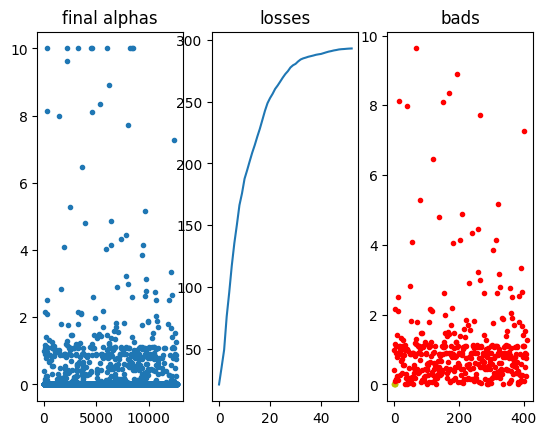

CPU times: user 25.1 s, sys: 46 ms, total: 25.2 s
Wall time: 25.2 s


In [13]:
%%time
s = mySVM(optimizer='smo', kernel="rbf", max_epochs=200_000,debug=2,smo_chooser=1,gamma=9., C=10, recal_bads=100)
s.fit(X,y)
# s = model.SVMs[(7,9)]   #97
print()
print(f'train acc: {100*(s.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s.predict(X_test)==y_test).sum()/len(y_test):.2f}')
s.plot()


comparasion of randomly choosing i and j uniformly or choosing from KKT violators.

In [32]:
%%time
# choose random
s_random = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=0,gamma=9., C=10)
s_random.fit(X,y)


CPU times: user 2min 8s, sys: 37.7 ms, total: 2min 8s
Wall time: 2min 8s


In [33]:
%%time
# calc violators and choose
s = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=9., C=10, recal_bads=100)
s.fit(X,y)

CPU times: user 2min 29s, sys: 35.1 ms, total: 2min 29s
Wall time: 2min 29s


In [38]:
%%time
# calc violators and choose
s_300 = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=9., C=10, recal_bads=300)
s_300.fit(X,y)

CPU times: user 2min 9s, sys: 29 ms, total: 2min 9s
Wall time: 2min 9s


In [39]:
%%time
# calc violators and choose
s_20 = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=9., C=10, recal_bads=20)
s_20.fit(X,y)

CPU times: user 4min 1s, sys: 61.7 ms, total: 4min 1s
Wall time: 4min 1s


In [41]:
%%time
# calc violators and choose
s_800 = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=9., C=10, recal_bads=800)
s_800.fit(X,y)

CPU times: user 2min 3s, sys: 44.4 ms, total: 2min 4s
Wall time: 2min 3s


In [43]:
%%time
# calc violators and choose
s_10000 = mySVM(optimizer='smo', kernel="rbf", max_epochs=100_000,debug=0,smo_chooser=1,gamma=9., C=10, recal_bads=10000)
s_10000.fit(X,y)

CPU times: user 2min 20s, sys: 37.5 ms, total: 2min 20s
Wall time: 2min 20s


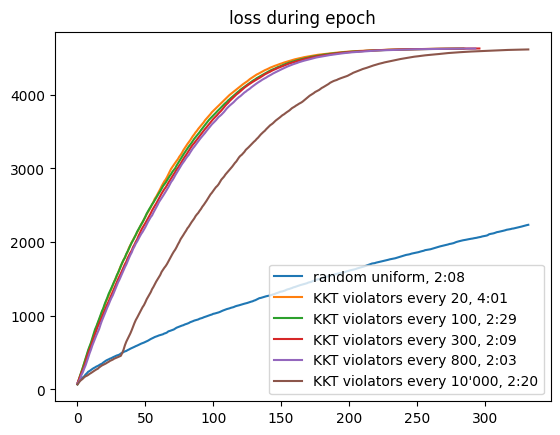

In [48]:
plt.title("loss during epoch")
plt.plot(s_random.losses,label="random uniform, 2:08")
plt.plot(s_20.losses,label="KKT violators every 20, 4:01")
plt.plot(s.losses,label="KKT violators every 100, 2:29")
plt.plot(s_300.losses,label="KKT violators every 300, 2:09")
plt.plot(s_800.losses,label="KKT violators every 800, 2:03")
plt.plot(s_10000.losses,label="KKT violators every 10'000, 2:20")
plt.legend()
plt.show()

comparing SMO and PGD

In [77]:
%%time
s_smo = mySVM(optimizer='smo', kernel="rbf", max_epochs=12_000,debug=1,smo_chooser=1,gamma=9., C=10, recal_bads=700)
s_smo.fit(X,y)
print(f'train acc: {100*(s_smo.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s_smo.predict(X_test)==y_test).sum()/len(y_test):.2f} # SVs: {s_smo.y_SVs.size}')


epochs 12000 final obj: 1852.94 sum all: 5240.41
train acc: 98.94  test acc: 97.35 # SVs: 2492
CPU times: user 18.3 s, sys: 12 ms, total: 18.4 s
Wall time: 18.3 s


In [75]:
%%time
s_smo = mySVM(optimizer='smo', kernel="rbf", max_epochs=200_000,debug=1,smo_chooser=1,gamma=9., C=10, recal_bads=700)
s_smo.fit(X,y)
print(f'train acc: {100*(s_smo.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s_smo.predict(X_test)==y_test).sum()/len(y_test):.2f}')


epochs 90601 final obj: 4628.19 sum all: 23636.14
train acc: 99.42  test acc: 97.84
CPU times: user 2min 7s, sys: 32.8 ms, total: 2min 7s
Wall time: 2min 7s


In [78]:
%%time
s_pgd = mySVM(optimizer='pgd', kernel="rbf",lr=3, max_epochs=10,debug=2, gamma=9., C=10)
s_pgd.fit(X,y)
print()
print(f'train acc: {100*(s_pgd.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s_pgd.predict(X_test)==y_test).sum()/len(y_test):.2f} # SVs: {s_pgd.y_SVs.size}')

[PGD optimizer] epoch = 0: L = -243.83187  (# of support vectors = 770)
                 alpha: max=7.177271331312023 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 1: L = -406.33880  (# of support vectors = 1114)
                 alpha: max=9.840135993751115 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 2: L = -690.59796  (# of support vectors = 1386)
                 alpha: max=9.999126583252165 min=0.0 orthogonal constraint=-0.00
[PGD optimizer] epoch = 3: L = -909.26739  (# of support vectors = 1648)
                 alpha: max=9.999999160994758 min=0.0 orthogonal constraint=-0.00
[PGD optimizer] epoch = 4: L = -1116.30291  (# of support vectors = 1833)
                 alpha: max=9.999999160994758 min=0.0 orthogonal constraint=-0.00
[PGD optimizer] epoch = 5: L = -1317.17366  (# of support vectors = 2023)
                 alpha: max=9.999999911368857 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 6: L = -1530.00199  (# of support vectors = 2168

In [68]:
%%time
s_pgd = mySVM(optimizer='pgd', kernel="rbf", lr=3. , max_epochs=200,debug=2, gamma=9., C=10)
s_pgd.fit(X,y)
print()
print(f'train acc: {100*(s_pgd.predict(X)==y).sum()/len(y):.2f}  test acc: {100*(s_pgd.predict(X_test)==y_test).sum()/len(y_test):.2f}')


[PGD optimizer] epoch = 0: L = -178.40779  (# of support vectors = 702)
                 alpha: max=5.929410827358447 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 1: L = -371.45909  (# of support vectors = 1013)
                 alpha: max=9.997088647643604 min=0.0 orthogonal constraint=-0.00
[PGD optimizer] epoch = 2: L = -613.18917  (# of support vectors = 1261)
                 alpha: max=9.997734397691342 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 3: L = -789.43414  (# of support vectors = 1516)
                 alpha: max=9.999998925321096 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 4: L = -1082.88423  (# of support vectors = 1704)
                 alpha: max=9.999998925321096 min=0.0 orthogonal constraint=0.00
[PGD optimizer] epoch = 5: L = -1268.75139  (# of support vectors = 1917)
                 alpha: max=9.9999999988048 min=0.0 orthogonal constraint=-0.00
[PGD optimizer] epoch = 6: L = -1433.48874  (# of support vectors = 2087)
 

In [74]:
s_pgd.y_SVs.shape

(2388,)

model votes: [5 5 5 9 1 7 2 0 8 3]
models pred: 3
actual label: 8


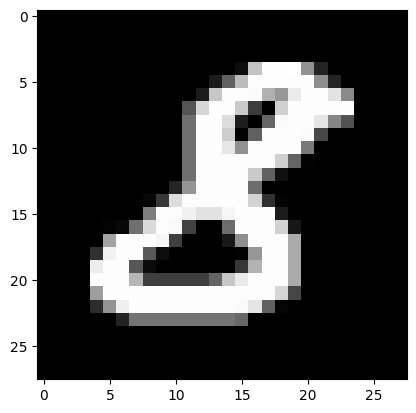

In [79]:
def show_img(img):
  img = img.reshape(28,-1)
  plt.imshow(img, cmap='gray')
  plt.show()

diffs = np.nonzero(model_preds.get()!=train_label)[0]

offset = cp.outer(cp.ones(model_f.shape[0],dtype=cp.int8) ,cp.arange(model_f.shape[-1],dtype=cp.int8))
model_votes = (offset - model_f.sum(axis=-2,dtype=cp.int8)) + model_f.sum(axis=-1,dtype=cp.int8)

i=200
idx = diffs[i]

print("model votes:", model_votes[idx])
print("models pred:",model_preds[idx])
print("actual label:",train_label[idx])
show_img(train_data[idx,:])

losses
0 1    (423,)
BADS (not KKT equality)
a=0 and a=C 2
0<a<C 414


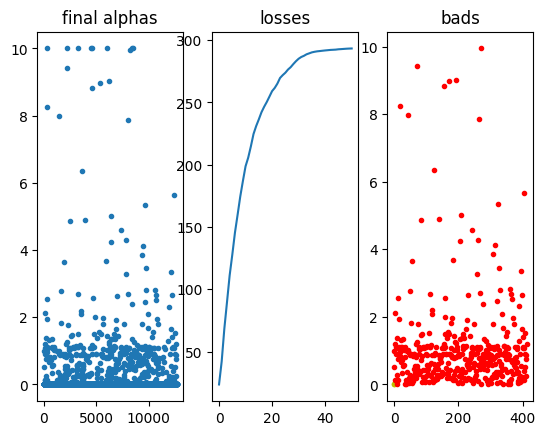

0 2    (671,)
BADS (not KKT equality)
a=0 and a=C 2
0<a<C 604


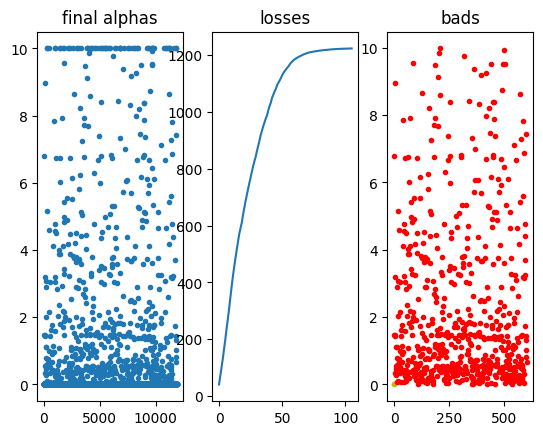

0 3    (602,)
BADS (not KKT equality)
a=0 and a=C 3
0<a<C 561


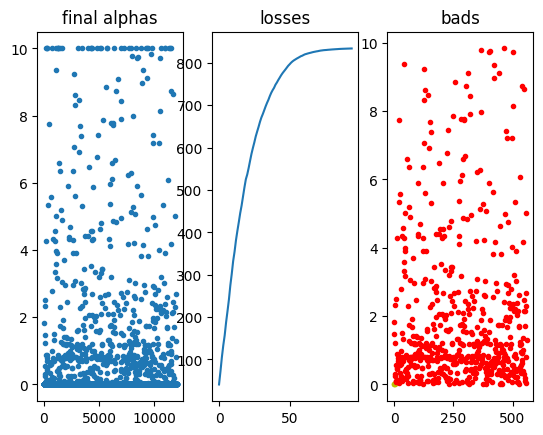

0 4    (576,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 556


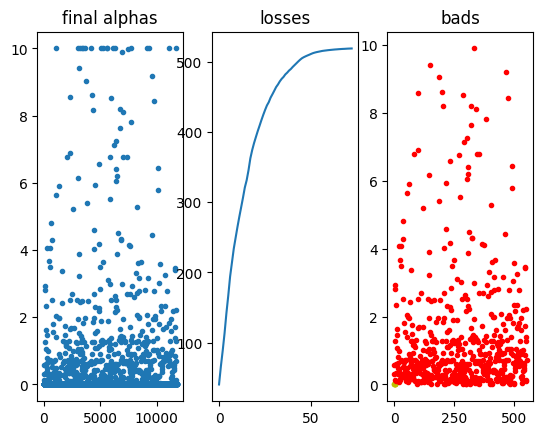

0 5    (788,)
BADS (not KKT equality)
a=0 and a=C 7
0<a<C 723


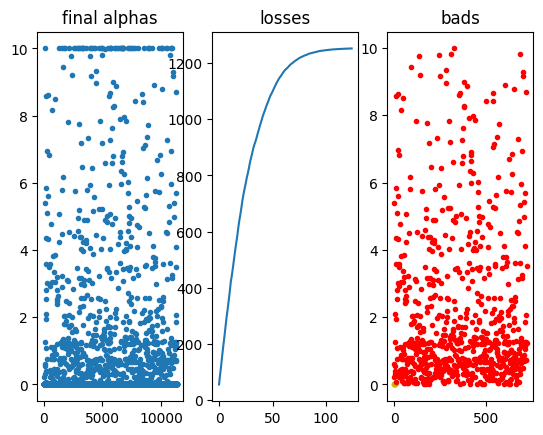

0 6    (662,)
BADS (not KKT equality)
a=0 and a=C 3
0<a<C 576


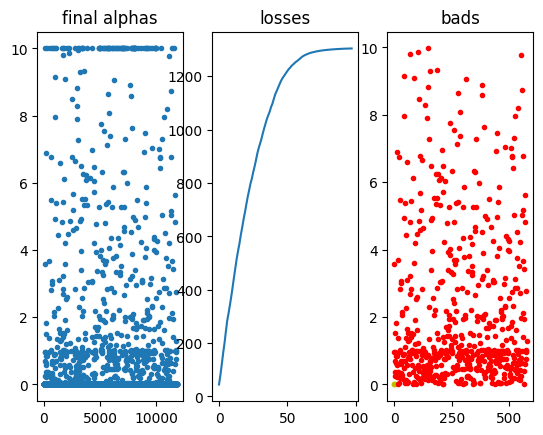

0 7    (501,)
BADS (not KKT equality)
a=0 and a=C 1
0<a<C 486


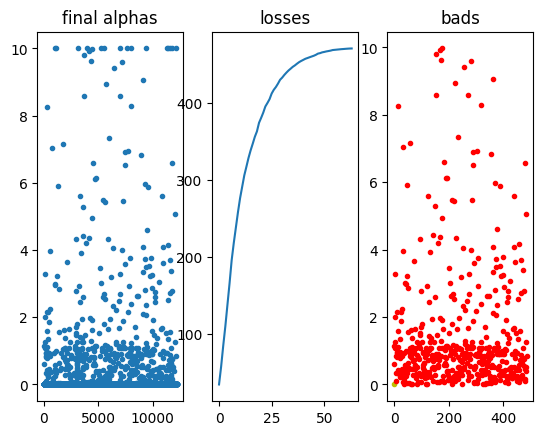

0 8    (690,)
BADS (not KKT equality)
a=0 and a=C 4
0<a<C 604


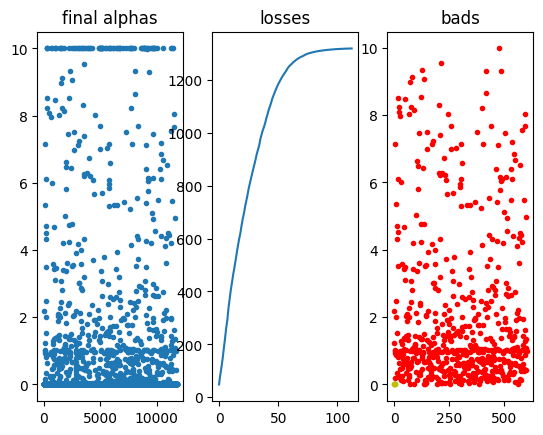

0 9    (574,)
BADS (not KKT equality)
a=0 and a=C 0
0<a<C 530


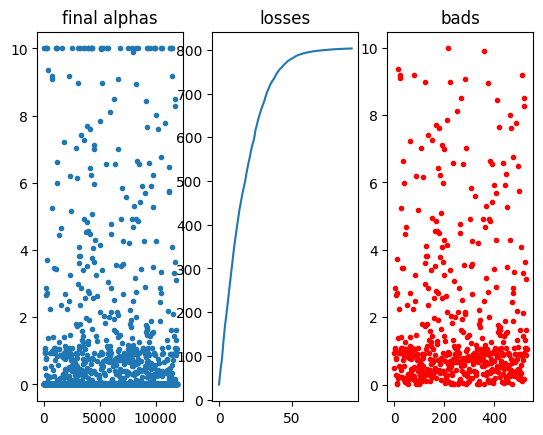

1 2    (695,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 605


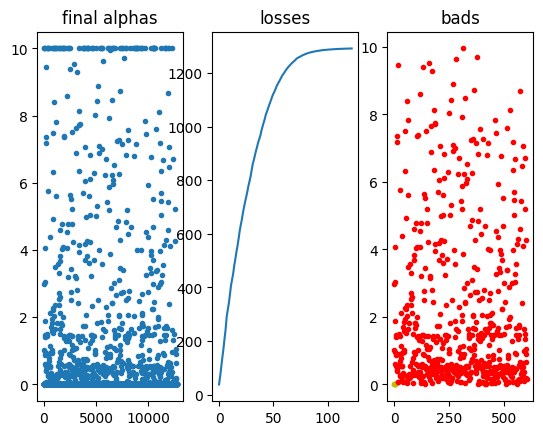

1 3    (648,)
BADS (not KKT equality)
a=0 and a=C 8
0<a<C 584


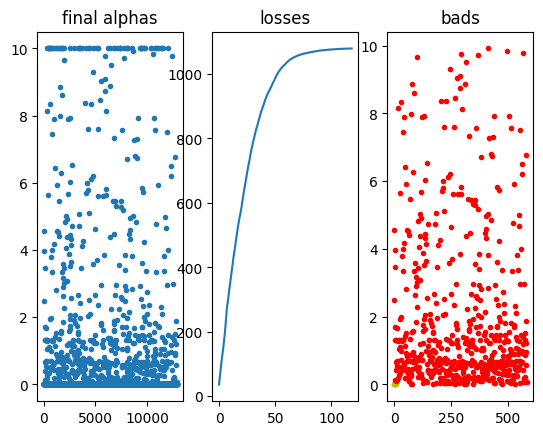

1 4    (584,)
BADS (not KKT equality)
a=0 and a=C 2
0<a<C 536


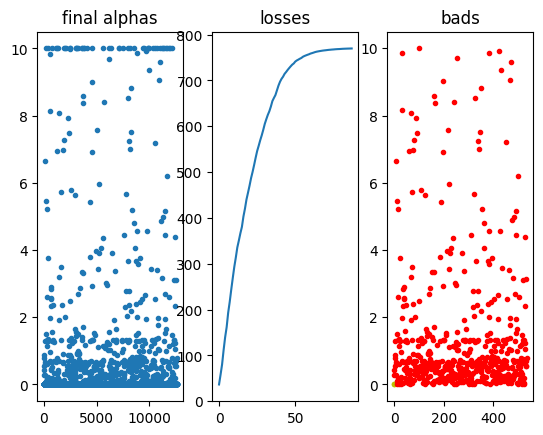

1 5    (631,)
BADS (not KKT equality)
a=0 and a=C 4
0<a<C 608


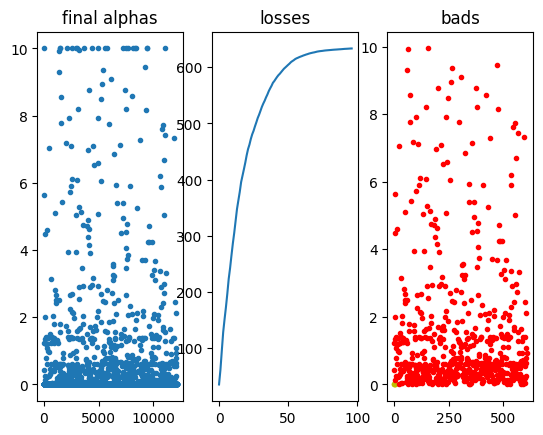

1 6    (532,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 502


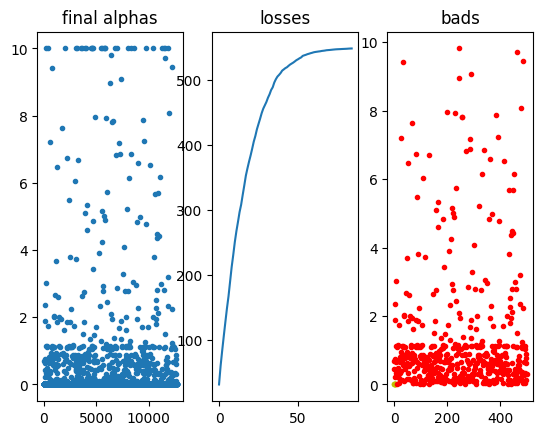

1 7    (646,)
BADS (not KKT equality)
a=0 and a=C 3
0<a<C 564


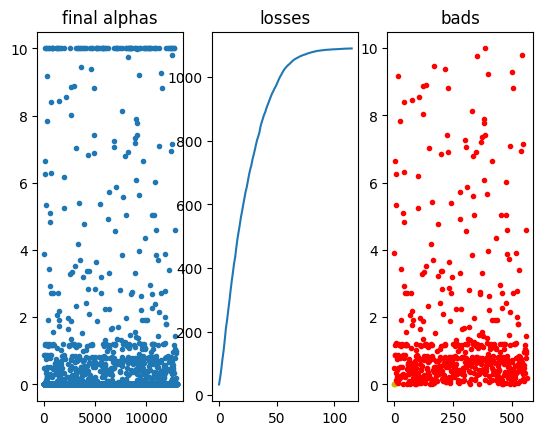

1 8    (884,)
BADS (not KKT equality)
a=0 and a=C 1
0<a<C 694


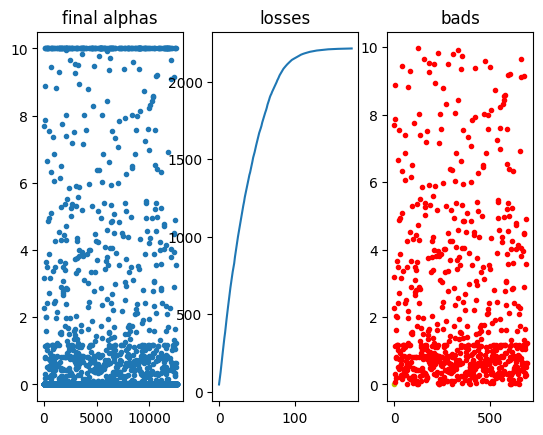

1 9    (633,)
BADS (not KKT equality)
a=0 and a=C 11
0<a<C 562


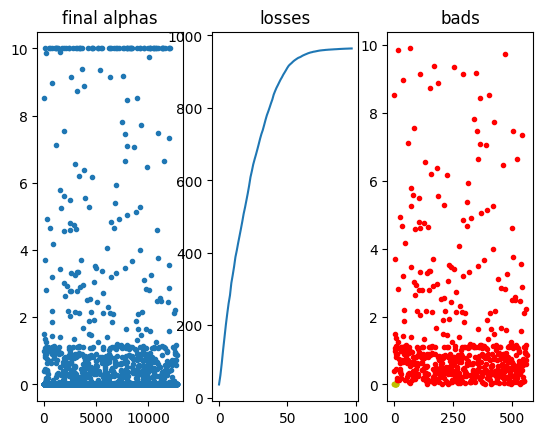

2 3    (1220,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 1010


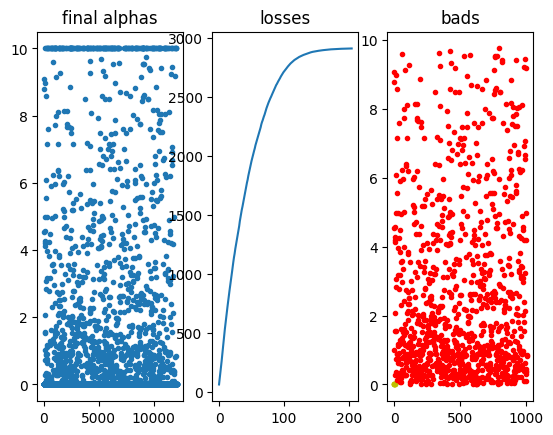

2 4    (810,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 766


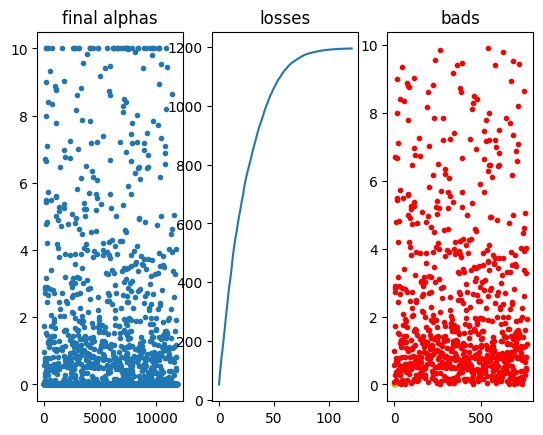

2 5    (845,)
BADS (not KKT equality)
a=0 and a=C 9
0<a<C 788


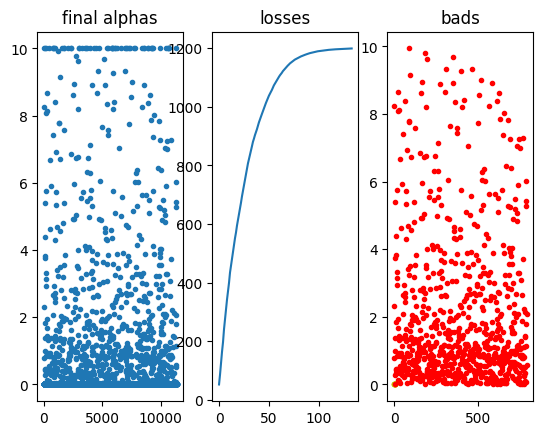

2 6    (726,)
BADS (not KKT equality)
a=0 and a=C 5
0<a<C 666


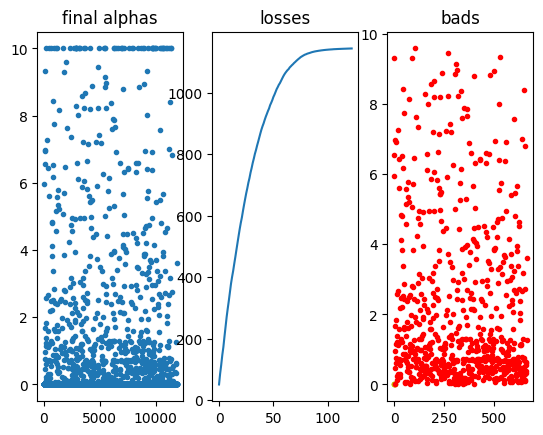

2 7    (831,)
BADS (not KKT equality)
a=0 and a=C 4
0<a<C 714


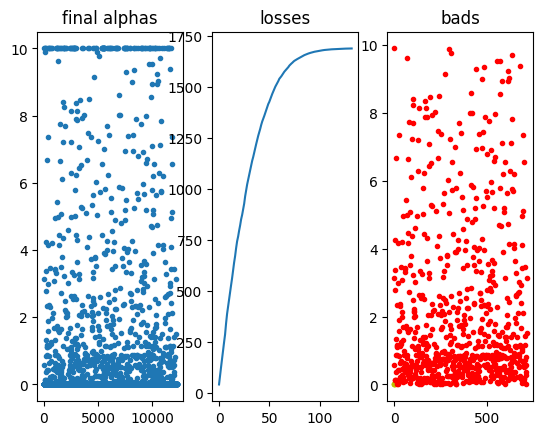

2 8    (1057,)
BADS (not KKT equality)
a=0 and a=C 3
0<a<C 858


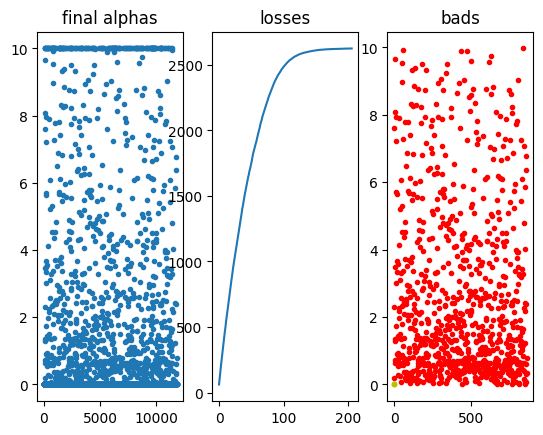

2 9    (695,)
BADS (not KKT equality)
a=0 and a=C 2
0<a<C 651


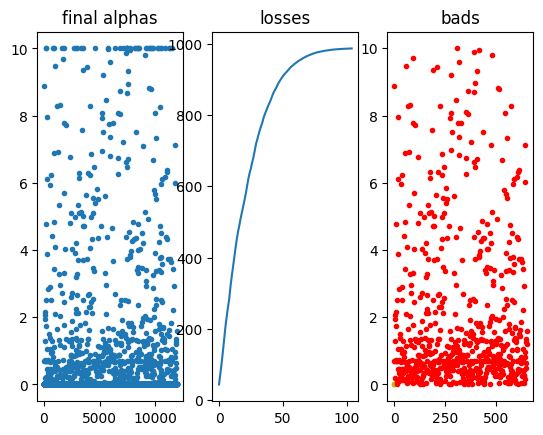

3 4    (633,)
BADS (not KKT equality)
a=0 and a=C 3
0<a<C 600


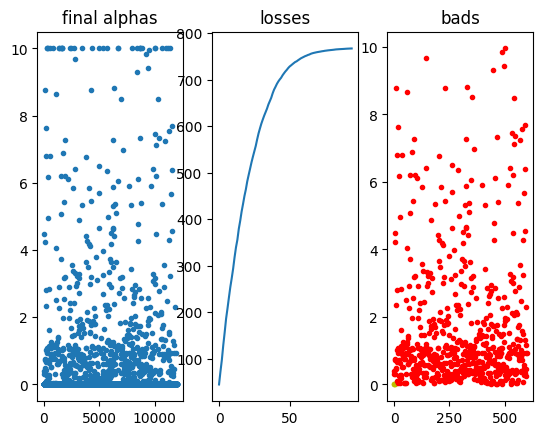

3 5    (1398,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 1075


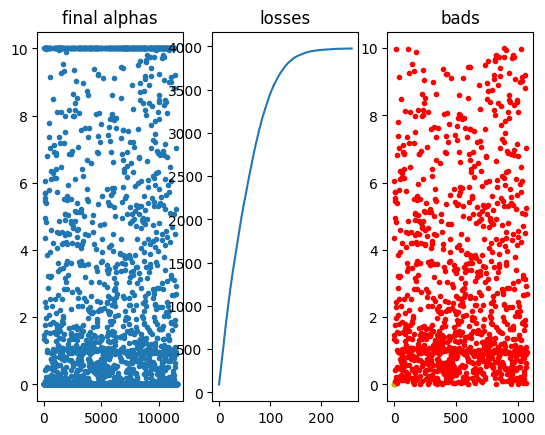

3 6    (522,)
BADS (not KKT equality)
a=0 and a=C 4
0<a<C 498


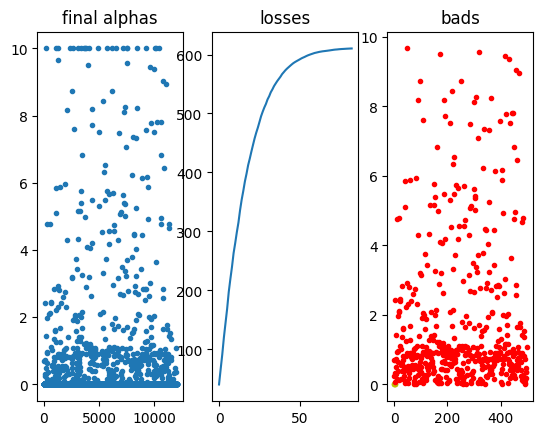

3 7    (781,)
BADS (not KKT equality)
a=0 and a=C 7
0<a<C 662


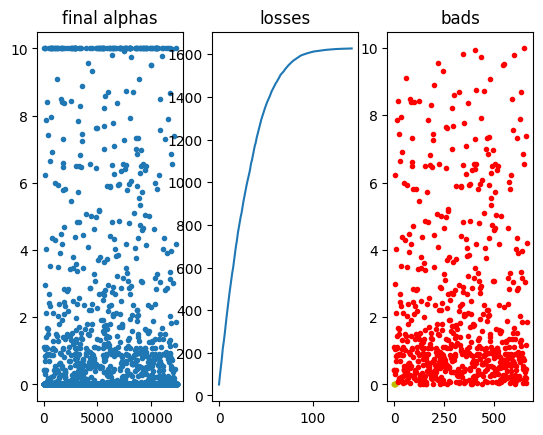

3 8    (1324,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 973


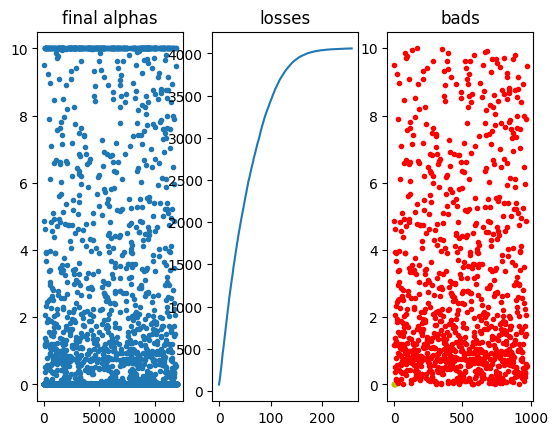

3 9    (874,)
BADS (not KKT equality)
a=0 and a=C 8
0<a<C 670


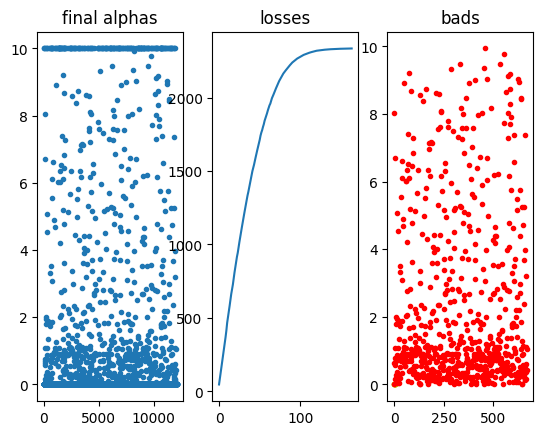

4 5    (783,)
BADS (not KKT equality)
a=0 and a=C 5
0<a<C 743


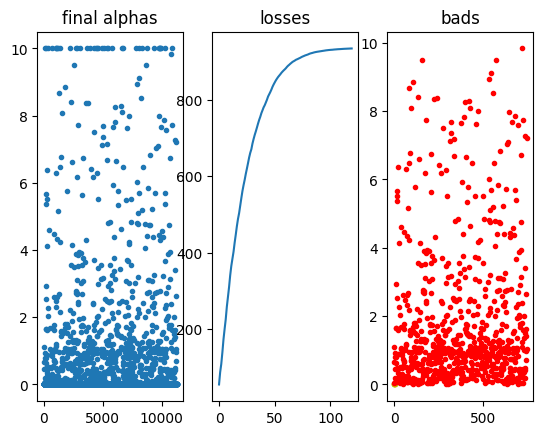

4 6    (706,)
BADS (not KKT equality)
a=0 and a=C 7
0<a<C 643


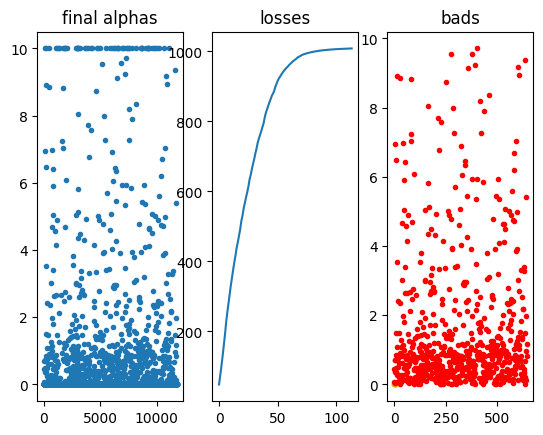

4 7    (873,)
BADS (not KKT equality)
a=0 and a=C 9
0<a<C 768


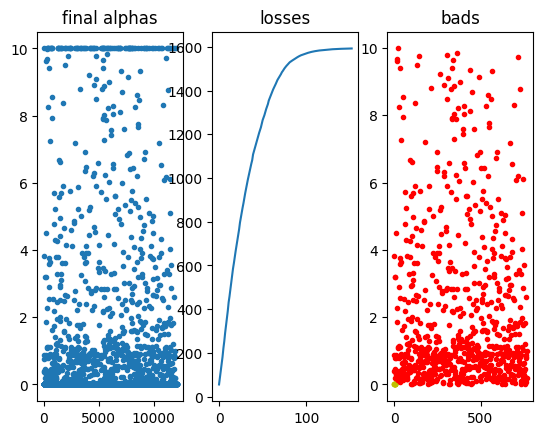

4 8    (790,)
BADS (not KKT equality)
a=0 and a=C 6
0<a<C 732


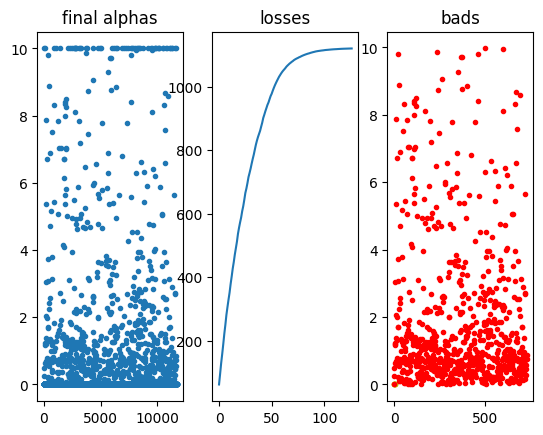

4 9    (1389,)
BADS (not KKT equality)
a=0 and a=C 5
0<a<C 980


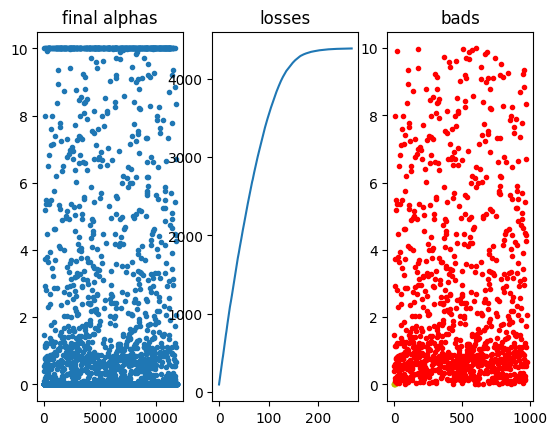

5 6    (865,)
BADS (not KKT equality)
a=0 and a=C 13
0<a<C 686


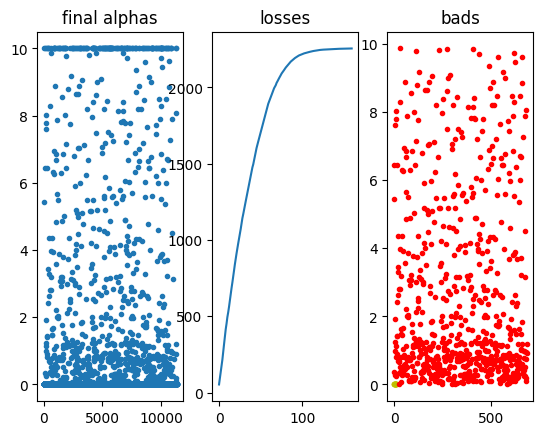

5 7    (627,)
BADS (not KKT equality)
a=0 and a=C 11
0<a<C 602


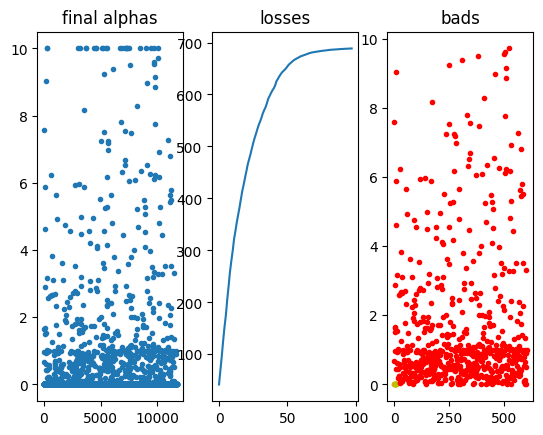

5 8    (1325,)
BADS (not KKT equality)
a=0 and a=C 7
0<a<C 1124


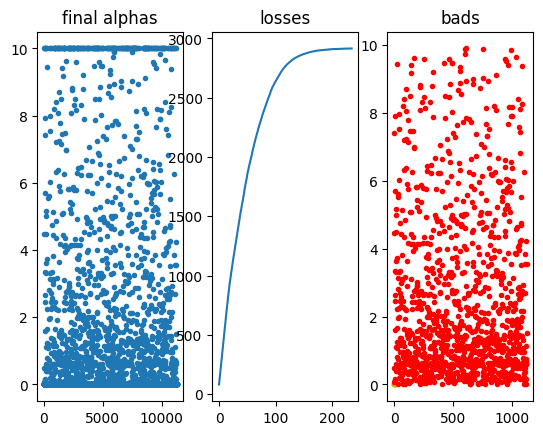

5 9    (828,)
BADS (not KKT equality)
a=0 and a=C 7
0<a<C 709


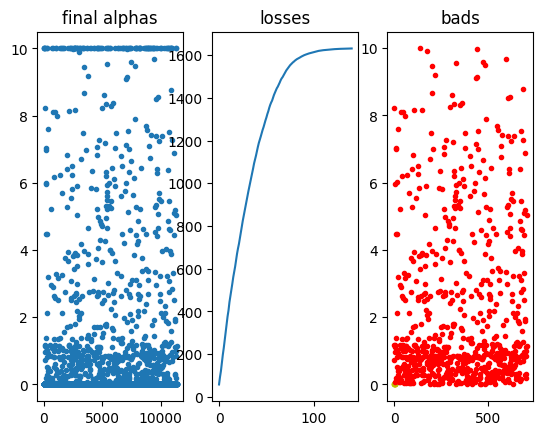

6 7    (536,)
BADS (not KKT equality)
a=0 and a=C 5
0<a<C 528


KeyboardInterrupt: 

In [32]:
print("losses")
l=1
for i in range(9):
    for j in range(i+1,10):
        # print(i,j)
        # print(i,j, "  ", model_5.SVMs[(i,j)].lower.shape[0] + model.SVMs[(i,j)].higher.shape[0])
        print(i,j, "  ", model_5.SVMs[(i,j)].y_SVs.shape)
        model_5.SVMs[(i,j)].plot()
# plt.show